In [1]:
#Import the data
import pandas as pd
#%pip install openpyxl

excel_file_path = '/Users/katherinecole/Downloads/Oncology_IO Data.xlsx'

df = pd.read_excel(excel_file_path)

print(df.head())



     ID   Cohort  Year of ICI treatment start Age at ICI start     Sex  \
0  8213  Initial                         2017          61 - 65  Female   
1  8214  Initial                         2018          66 - 70  Female   
2  8215  Initial                         2018          61 - 65  Female   
3  8216  Initial                         2015          56 - 60  Female   
4  8217  Initial                         2018          51 - 55  Female   

   Cancer type   NLR  MSI type  TMB (Mutations/Mb) ICI drug class  \
0   Colorectal  7.60       NaN                 4.9     PD-1/PD-L1   
1  Endometrial  1.19  Unstable                32.5     PD-1/PD-L1   
2         SCLC  1.38    Stable                19.3     PD-1/PD-L1   
3     Melanoma  2.69    Stable                 1.0          Combo   
4        NSCLC  2.54    Stable                10.5     PD-1/PD-L1   

  Best Response Response to ICI Clinical Benefit with ICI Progression  \
0            PD              No                        No         Y

In [2]:
#Quick Descriptive statistics- 

#Get list of column name. These names will be modified later in the code to simplify analysis
print(df.columns. values. tolist())

#Identify number of rows and columns
print(df.shape)

['ID', 'Cohort', 'Year of ICI treatment start', 'Age at ICI start', 'Sex', 'Cancer type', 'NLR', 'MSI type', 'TMB (Mutations/Mb)', 'ICI drug class', 'Best Response', 'Response to ICI', 'Clinical Benefit with ICI', 'Progression', 'Progression-Free Survival (Months)', 'Vital status', 'Overall Survival (Months)', 'Stage at ICI start', 'ICI line of treatment', 'ECOG PS']
(2037, 20)


In [3]:
#Identify column types
column_types = df.dtypes
print(column_types)

#Assess for missing values, and make sure missing values are identified correctly

missing_values = df.isnull().sum()
print(missing_values)

ID                                      int64
Cohort                                 object
Year of ICI treatment start             int64
Age at ICI start                       object
Sex                                    object
Cancer type                            object
NLR                                   float64
MSI type                               object
TMB (Mutations/Mb)                    float64
ICI drug class                         object
Best Response                          object
Response to ICI                        object
Clinical Benefit with ICI              object
Progression                            object
Progression-Free Survival (Months)    float64
Vital status                           object
Overall Survival (Months)             float64
Stage at ICI start                     object
ICI line of treatment                  object
ECOG PS                               float64
dtype: object
ID                                      0
Cohort                  

In [4]:
df.info() #This is another way to view the number of non-missing values, and to get the Dtype for the column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  2037 non-null   int64  
 1   Cohort                              2037 non-null   object 
 2   Year of ICI treatment start         2037 non-null   int64  
 3   Age at ICI start                    2037 non-null   object 
 4   Sex                                 2037 non-null   object 
 5   Cancer type                         2037 non-null   object 
 6   NLR                                 2037 non-null   float64
 7   MSI type                            1691 non-null   object 
 8   TMB (Mutations/Mb)                  2037 non-null   float64
 9   ICI drug class                      2037 non-null   object 
 10  Best Response                       2037 non-null   object 
 11  Response to ICI                     2037 no

## 1. Data Cleaning

In [5]:
#The function was adapted from a function that I previously made in R

#It essentially modifies all column names to lowercase, replaces any non alphanumeric characters with underscores, and gets rid of XS spaces

import re

#define the clean_names function
def clean_names(x):
    #replace all variable names to lowercase
    x = x.lower()
    # Replace any character NOT alphanumeric with underscore
    x = re.sub(r'[^a-zA-Z0-9]', '_', x)
    # Replace two or more underscores with a single underscore
    x = re.sub(r'_{2,}', '_', x)
    # Replace any non-alphabetic character at the beginning with empty string
    x = re.sub(r'^[^a-zA-Z]+', '', x)
    # Replace any non-alphanumeric character at the end with empty string
    x = re.sub(r'[^a-zA-Z0-9]+$', '', x)
    return x

# Function to clean column names
def clean_column_names(df):
    df.columns = [clean_names(col) for col in df.columns]
    return df

# Clean column names
data_clean = clean_column_names(df)

print(data_clean.columns)


Index(['id', 'cohort', 'year_of_ici_treatment_start', 'age_at_ici_start',
       'sex', 'cancer_type', 'nlr', 'msi_type', 'tmb_mutations_mb',
       'ici_drug_class', 'best_response', 'response_to_ici',
       'clinical_benefit_with_ici', 'progression',
       'progression_free_survival_months', 'vital_status',
       'overall_survival_months', 'stage_at_ici_start',
       'ici_line_of_treatment', 'ecog_ps'],
      dtype='object')


In [6]:
#Rename the column names

data_clean = data_clean.rename(columns={
        'year_of_ici_treatment_start': 'tx_year', 
        'progression_free_survival_months': 'PFS', 
        'overall_survival_months': 'OS',
        'clinical_benefit_with_ici': 'clin_benefit',
        'age_at_ici_start': 'age',
        'ici_drug_class': 'drug_class',
        'response_to_ici': 'response',
        'stage_at_ici_start': 'stage',
        'ecog_ps': 'ECOG',
        'ici_line_of_treatment': 'tx_line'
})
print(data_clean.columns)


Index(['id', 'cohort', 'tx_year', 'age', 'sex', 'cancer_type', 'nlr',
       'msi_type', 'tmb_mutations_mb', 'drug_class', 'best_response',
       'response', 'clin_benefit', 'progression', 'PFS', 'vital_status', 'OS',
       'stage', 'tx_line', 'ECOG'],
      dtype='object')


In [7]:

#Print the number of unique levels per column to identify if any abberant categories (eg. categories identified as unique due to differences in string case)

#We note that there are 4 different levels fo the "alive" status, which will need to be collapsed into one category

object_columns = data_clean.select_dtypes(include=['object']).columns
for col in object_columns:
    unique_levels = data_clean[col].unique()
    print(f"Unique levels for column '{col}': {unique_levels}")

Unique levels for column 'cohort': ['Initial' 'Validation']
Unique levels for column 'age': ['61 - 65' '66 - 70' '56 - 60' '51 - 55' '71 - 75' '76 - 80' '91 - 95'
 '81 - 85' '86 - 90' '46 - 50' '36 - 40' '41 - 45' '21 - 25' '31 - 35'
 '26 - 30' '11 - 15' '16 - 20' '0 - 5' '6 - 10']
Unique levels for column 'sex': ['Female' 'Male']
Unique levels for column 'cancer_type': ['Colorectal' 'Endometrial' 'SCLC' 'Melanoma' 'NSCLC' 'Hepatobiliary'
 'Gastric' 'Pancreatic' 'Renal' 'Bladder' 'Sarcoma' 'Esophageal'
 'Head & Neck' 'Ovarian' 'Breast' 'Mesothelioma' 'CNS' 'Unknown primary']
Unique levels for column 'msi_type': [nan 'Unstable' 'Stable' 'Indeterminate']
Unique levels for column 'drug_class': ['PD-1/PD-L1' 'Combo' 'CTLA-4' 'combo']
Unique levels for column 'best_response': ['PD' 'PR' 'CR' 'SD']
Unique levels for column 'response': ['No' 'Yes']
Unique levels for column 'clin_benefit': ['No' 'Yes']
Unique levels for column 'progression': ['Yes' 'No']
Unique levels for column 'vital_status'

In [8]:
#Restrict analysis to adults only (exclude kids)

excluded_categories_age = ['0 - 5', '6 - 10', '11 - 15', '16 - 20']
data_clean1 = data_clean[~data_clean['age'].isin(excluded_categories_age)]
#print(data_clean2)

#Exclude gynecological cancers and cancers with low counts/low responsiveness to checkpoint inhibitor therapy
excluded_categories_cancer = ['Endometrial', 'Sarcoma', 'Breast', 'Ovarian', 'Mesothelioma', 'CNS', 'Unknown primary']
data_clean2 = data_clean1[~data_clean1['cancer_type'].isin(excluded_categories_cancer)]

#check variable levels properly excluded
unique_levels2 = data_clean2['age'].unique()
print(unique_levels2)

unique_levels2 = data_clean2['cancer_type'].unique()
print(unique_levels2)


['61 - 65' '56 - 60' '51 - 55' '66 - 70' '71 - 75' '76 - 80' '81 - 85'
 '86 - 90' '46 - 50' '36 - 40' '41 - 45' '21 - 25' '26 - 30' '31 - 35'
 '91 - 95']
['Colorectal' 'SCLC' 'Melanoma' 'NSCLC' 'Hepatobiliary' 'Gastric'
 'Pancreatic' 'Renal' 'Bladder' 'Esophageal' 'Head & Neck']


In [10]:

#Map age into 10 year blocks
mapping_age = {'21 - 25': '21 - 30', '26 - 30': '21 - 30', '31 - 35': '31 - 40', 
           '36 - 40': '31 - 40', '41 - 45': '41 - 50', '46 - 50': '41 - 50',
           '51 - 55': '51 - 60', '56 - 60': '51 - 60',
           '61 - 65': '61 - 70', '66 - 70': '61 - 70',
           '71 - 75': '71 - 80', '76 - 80': '71 - 80', '81 -86': '81+', '86 - 90': '81+', '91 - 95': '81+'}

# Regroup the categorical variable using the mapping
data_clean2['age'] = data_clean2['age'].replace(mapping_age)

mapping_cancer2 = { 'Colorectal':'LGI',
              
                  'SCLC': 'Lung',
                  'Melanoma': 'Melanoma',
                  'Hepatobiliary': 'UGI',
                  'NSCLC': 'Lung',
                  'Gastric': 'UGI',
                  'Pancreatic': 'UGI',
                  'Renal': 'GU',
                  'Bladder': 'GU',
                  'Esophageal': 'UGI',
                  'Head & Neck': 'HNC',
    
}



data_clean2['cancer_type'] = data_clean2['cancer_type'].replace(mapping_cancer2)

print(data_clean2)

unique_levels2 = data_clean2['age'].unique()
unique_levels2 = data_clean2['cancer_type'].unique()
print(unique_levels2)



         id      cohort  tx_year      age     sex cancer_type    nlr msi_type  \
0      8213     Initial     2017  61 - 70  Female         LGI   7.60      NaN   
2      8215     Initial     2018  61 - 70  Female        Lung   1.38   Stable   
3      8216     Initial     2015  51 - 60  Female    Melanoma   2.69   Stable   
4      8217     Initial     2018  51 - 60  Female        Lung   2.54   Stable   
5      8218     Initial     2017  61 - 70  Female         UGI   3.32      NaN   
...     ...         ...      ...      ...     ...         ...    ...      ...   
2032  10541  Validation     2019  31 - 40    Male         HNC   9.67   Stable   
2033  10542  Validation     2019  41 - 50    Male          GU   2.39   Stable   
2034  10543  Validation     2019  41 - 50    Male          GU   1.46   Stable   
2035  10544  Validation     2019  31 - 40    Male          GU   2.40   Stable   
2036  10545  Validation     2019  61 - 70  Female          GU  14.00   Stable   

      tmb_mutations_mb  dru

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/3528736458.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['age'] = data_clean2['age'].replace(mapping_age)
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/3528736458.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['cancer_type'] = data_clean2['cancer_type'].replace(mapping_cancer2)


In [11]:
#Summarize categorical variables in summary tables

categorical_variables = ['age', 'progression', 'vital_status', 'drug_class','msi_type','best_response', 'response', 'clin_benefit','stage','tx_line', 'sex', 'cancer_type']

# Generate summary tables for each categorical variable
summary_tables = {}
for variable in categorical_variables:
    summary_table = data_clean2[variable].value_counts().reset_index()
    summary_table.columns = [variable, 'Count']
    summary_tables[variable] = summary_table

# Print summary tables
for variable, table in summary_tables.items():
    print(f"\nSummary table for '{variable}':")
    print(table)



Summary table for 'age':
       age  Count
0  61 - 70    592
1  51 - 60    398
2  71 - 80    334
3  41 - 50    167
4  81 - 85     70
5  31 - 40     67
6  21 - 30     26
7      81+     25

Summary table for 'progression':
  progression  Count
0         Yes   1389
1          No    290

Summary table for 'vital_status':
  vital_status  Count
0         Dead    994
1        Alive    652
2        ALIVE     30
3       Alive       2
4        alive      1

Summary table for 'drug_class':
   drug_class  Count
0  PD-1/PD-L1   1392
1       Combo    253
2       combo     29
3      CTLA-4      5

Summary table for 'msi_type':
        msi_type  Count
0         Stable   1312
1  Indeterminate     47
2       Unstable     35

Summary table for 'best_response':
  best_response  Count
0            PD    837
1            SD    371
2            PR    370
3            CR    101

Summary table for 'response':
  response  Count
0       No   1208
1      Yes    471

Summary table for 'clin_benefit':
  clin_benef

In [12]:

#colate 'vital_status' values
data_clean2['vital_status'] = data_clean2['vital_status'].str.lower().replace({'alive ': 'alive', 'alive': 'alive'})

# Generate summary table for 'vital_status'
summary_table = data_clean2['vital_status'].value_counts().reset_index()
summary_table.columns = ['vital_status', 'Count']

print(summary_table)


#colate 'drug class' values given low counts for CTLA4
data_clean2['drug_class'] = data_clean2['drug_class'].str.lower().replace({'combo': 'ctla4/combo'})
data_clean2['drug_class'] = data_clean2['drug_class'].str.lower().replace({'combo': 'ctla4/combo'})
data_clean2['drug_class'] = data_clean2['drug_class'].str.lower().replace({'ctla-4': 'ctla4/combo'})

# Generate summary table for 'drug_class'
summary_table = data_clean2['drug_class'].value_counts().reset_index()
summary_table.columns = ['drug_class', 'Count']

print(summary_table)

#colate stage variable

data_clean2['stage'] = data_clean2['stage'].str.lower().replace({'i': 'local'})
data_clean2['stage'] = data_clean2['stage'].str.lower().replace({'ii': 'local'})
data_clean2['stage'] = data_clean2['stage'].str.lower().replace({'iii': 'local'})
data_clean2['stage'] = data_clean2['stage'].str.lower().replace({'iv': 'advanced'})
# Generate summary table for 'drug_class'
summary_table = data_clean2['stage'].value_counts().reset_index()
summary_table.columns = ['stage', 'Count']

print(summary_table)

#colate ecog variable

# Convert the values in the 'ECOG' column to strings
data_clean2['ECOG'] = data_clean2['ECOG'].astype(str)

# Replace specific values in the 'ECOG' column
data_clean2['ECOG'] = data_clean2['ECOG'].replace({'2.0': '2+', '3.0': '2+', '4.0': '2+'})

# Create a summary table showing the counts of each unique value in the 'ECOG' column
summary_table = data_clean2['ECOG'].value_counts().reset_index()

# Rename the columns of the summary table
summary_table.columns = ['ECOG', 'Count']

print(summary_table)





  vital_status  Count
0         dead    994
1        alive    685
    drug_class  Count
0   pd-1/pd-l1   1392
1  ctla4/combo    287
      stage  Count
0  advanced   1561
1     local     97
  ECOG  Count
0  1.0    845
1  0.0    579
2   2+    133
3  nan    122


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/3646471020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['vital_status'] = data_clean2['vital_status'].str.lower().replace({'alive ': 'alive', 'alive': 'alive'})
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/3646471020.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['drug_class'] = data_clean2['drug_class'].str.lower().replace({'combo': 'ctla4/combo'})
/var/folders/k2/h7t5byyn0_sc57mcln13ql

## Exploratory Analysis

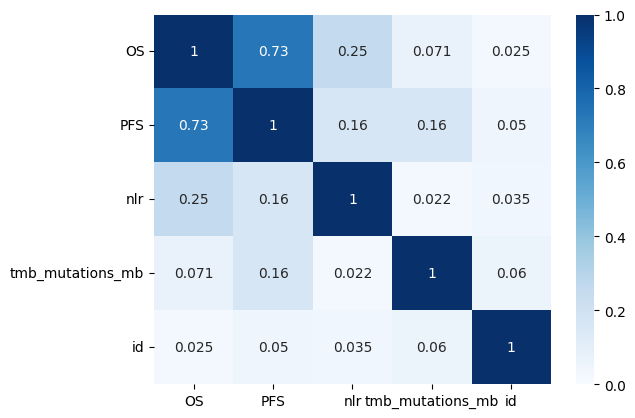

In [13]:
columns_correlation = ['OS', "PFS", "nlr", "tmb_mutations_mb", "id"] #I included ID as a quality control.
selected_columns = data_clean2[columns_correlation]

import seaborn as sns
import matplotlib.pyplot as plt
correlation=selected_columns.corr().abs()
heatmap = sns.heatmap(correlation, vmin=0, vmax=1, annot=True, cmap='Blues')
plt.show()

In [14]:
#Check correlations between vital status, and other continuous variables in the model. #ID included as quality check, which has a 
#slightly higher correlation than I would have expected.

# Compute direct correlations of selected features with the target variable
correlations_original = data_clean2.corrwith(data_clean2['vital_status'],method='spearman')
# Sort them according the strength of correlations.
correlations_index = correlations_original.abs().sort_values(kind="quicksort", ascending=False).index
# Use index to sort correlations
correlations = correlations_original[correlations_index]
# Display correlation value from original dataframe
correlations_df = pd.DataFrame(correlations, index=correlations.index, columns=['Correlation'])
# Print correlations
display(correlations_df)

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/2288697544.py:5: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_original = data_clean2.corrwith(data_clean2['vital_status'],method='spearman')


,Correlation
OS,-0.591353
PFS,-0.572407
nlr,0.259953
tx_year,-0.143015
id,-0.118482
tmb_mutations_mb,-0.084494


In [15]:
from sksurv.preprocessing import OneHotEncoder

# Convert specific columns to categorical dtype

columns_to_convert = ['response', 'clin_benefit', 'cancer_type', 'sex', 'cohort', 'drug_class', 'progression']  # List of columns to convert
data_clean2[columns_to_convert] = data_clean2[columns_to_convert].astype('category')

# Apply OneHotEncoder
encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(data_clean2[columns_to_convert])

# Concatenate the encoded DataFrame with data_clean
data_clean_encoded = pd.concat([data_clean2.drop(columns=columns_to_convert), data_encoded], axis=1)

print(data_clean_encoded)



         id  tx_year      age    nlr msi_type  tmb_mutations_mb best_response  \
0      8213     2017  61 - 70   7.60      NaN               4.9            PD   
2      8215     2018  61 - 70   1.38   Stable              19.3            PR   
3      8216     2015  51 - 60   2.69   Stable               1.0            PD   
4      8217     2018  51 - 60   2.54   Stable              10.5            PR   
5      8218     2017  61 - 70   3.32      NaN               6.1            PD   
...     ...      ...      ...    ...      ...               ...           ...   
2032  10541     2019  31 - 40   9.67   Stable               3.5            PD   
2033  10542     2019  41 - 50   2.39   Stable               4.4            PD   
2034  10543     2019  41 - 50   1.46   Stable               2.6            SD   
2035  10544     2019  31 - 40   2.40   Stable               2.6            PD   
2036  10545     2019  61 - 70  14.00   Stable               4.4            PR   

        PFS vital_status   

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/1548144996.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2[columns_to_convert] = data_clean2[columns_to_convert].astype('category')


In [16]:
data_clean_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 0 to 2036
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1679 non-null   int64  
 1   tx_year                1679 non-null   int64  
 2   age                    1679 non-null   object 
 3   nlr                    1679 non-null   float64
 4   msi_type               1394 non-null   object 
 5   tmb_mutations_mb       1679 non-null   float64
 6   best_response          1679 non-null   object 
 7   PFS                    1679 non-null   float64
 8   vital_status           1679 non-null   object 
 9   OS                     1679 non-null   float64
 10  stage                  1658 non-null   object 
 11  tx_line                1679 non-null   object 
 12  ECOG                   1679 non-null   object 
 13  response=Yes           1679 non-null   float64
 14  clin_benefit=Yes       1679 non-null   float64
 15  canc

In [17]:
#Missing data was handled by complete case analysis
data_complete = data_clean_encoded.dropna()
display(data_complete)
data_complete.info()

,id,tx_year,age,nlr,msi_type,tmb_mutations_mb,best_response,PFS,vital_status,OS,...,clin_benefit=Yes,cancer_type=HNC,cancer_type=LGI,cancer_type=Lung,cancer_type=Melanoma,cancer_type=UGI,sex=Male,cohort=Validation,drug_class=pd-1/pd-l1,progression=Yes
2,8215,2018,61 - 70,1.38,Stable,19.3,PR,3.45,alive,9.59,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,8216,2015,51 - 60,2.69,Stable,1.0,PD,0.56,alive,50.14,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8217,2018,51 - 60,2.54,Stable,10.5,PR,4.67,alive,9.99,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6,8219,2017,51 - 60,5.21,Stable,0.0,PR,8.61,dead,18.83,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
7,8220,2015,61 - 70,3.89,Stable,2.0,PD,0.99,dead,1.64,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,10541,2019,31 - 40,9.67,Stable,3.5,PD,2.00,dead,9.86,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2033,10542,2019,41 - 50,2.39,Stable,4.4,PD,2.63,alive,13.31,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2034,10543,2019,41 - 50,1.46,Stable,2.6,SD,10.48,dead,10.48,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2035,10544,2019,31 - 40,2.40,Stable,2.6,PD,3.22,alive,10.51,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1378 entries, 2 to 2036
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1378 non-null   int64  
 1   tx_year                1378 non-null   int64  
 2   age                    1378 non-null   object 
 3   nlr                    1378 non-null   float64
 4   msi_type               1378 non-null   object 
 5   tmb_mutations_mb       1378 non-null   float64
 6   best_response          1378 non-null   object 
 7   PFS                    1378 non-null   float64
 8   vital_status           1378 non-null   object 
 9   OS                     1378 non-null   float64
 10  stage                  1378 non-null   object 
 11  tx_line                1378 non-null   object 
 12  ECOG                   1378 non-null   object 
 13  response=Yes           1378 non-null   float64
 14  clin_benefit=Yes       1378 non-null   float64
 15  canc

In [18]:
data_complete.describe() #treating all as continuous. Still need to store tx_year as a year


,id,tx_year,nlr,tmb_mutations_mb,PFS,OS,response=Yes,clin_benefit=Yes,cancer_type=HNC,cancer_type=LGI,cancer_type=Lung,cancer_type=Melanoma,cancer_type=UGI,sex=Male,cohort=Validation,drug_class=pd-1/pd-l1,progression=Yes
count,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000
mean,9380.248911,2016.936865,6.412453,10.568215,7.596923,14.449702,0.283745,0.349057,0.076923,0.045718,0.426705,0.104499,0.135704,0.606676,0.140784,0.841074,0.825835
std,696.444125,1.090497,6.853801,18.194561,10.417434,12.187060,0.450978,0.476845,0.266566,0.208950,0.494778,0.306018,0.342598,0.488665,0.347925,0.365740,0.379389
min,8215.000000,2014.000000,0.470000,0.000000,0.030000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8749.250000,2016.000000,2.830000,3.500000,1.450000,4.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,9460.500000,2017.000000,4.380000,5.900000,2.790000,11.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,9945.250000,2018.000000,7.380000,10.800000,9.652500,20.440000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,10545.000000,2019.000000,87.000000,368.600000,67.220000,67.220000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


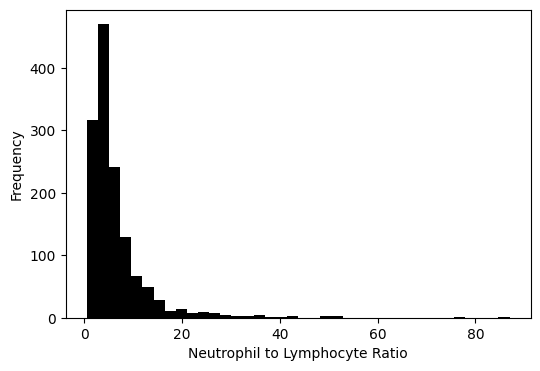

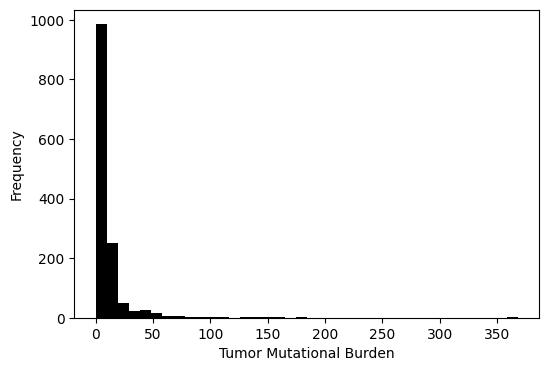

In [19]:
#Histogram of continuous variables

import numpy as np

n_bins = int(np.ceil(np.sqrt(data_complete.shape[0])))

# Plot histogram for nlr
# Set figure size
plt.figure(figsize=(6, 4))
plt.hist(data_complete['nlr'], bins=n_bins, color="black")
plt.xlabel('Neutrophil to Lymphocyte Ratio')
plt.ylabel('Frequency')
plt.show()



# Calculates number of bins for the histograms by taking the square root of the number of data points (comes out as 50)
n_bins = int(np.ceil(np.sqrt(data_complete.shape[0])))

# Plot histogram for nlr
# Set figure size
plt.figure(figsize=(6, 4))
plt.hist(data_complete['tmb_mutations_mb'], bins=n_bins, color="black")
plt.xlabel('Tumor Mutational Burden')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Create Ydata_Profiling Summary
from ydata_profiling import ProfileReport
profile=ProfileReport(data_complete, title="Merged Summary")
#profile.to_notebook_iframe()
profile.to_file("merged_summary_report.pdf")

## Kaplan Meier Survival Analysis

In [20]:

from sksurv.nonparametric import kaplan_meier_estimator

In [21]:
#Convert vital status variable to 1=dead and 0=alive

print(data_complete['vital_status'].unique())

data_complete['vital_status'] = data_complete['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')
print(data_complete['vital_status'])


['alive' 'dead']
2       0.0
3       0.0
4       0.0
6       1.0
7       1.0
       ... 
2032    1.0
2033    0.0
2034    1.0
2035    0.0
2036    0.0
Name: vital_status, Length: 1378, dtype: float64


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/3278137491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete['vital_status'] = data_complete['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')


In [22]:
from sklearn.preprocessing import OrdinalEncoder

#This was done mainly to permit CoxPH analysis, as there were issues with collinearity due to the large number of dummy encoded variables.

# Initialize the encoder
encoder = OrdinalEncoder()

# List of variables to encode
variables_to_encode = ['age', 'best_response', 'stage', 'ECOG', 'msi_type', 'tx_line']

# Fit and transform all variables at once
encoded_vars = encoder.fit_transform(data_complete[variables_to_encode])

# Add the encoded variables back to the DataFrame
for i, var in enumerate(variables_to_encode):
    data_complete[f'{var}_encoded'] = encoded_vars[:, i]

# Print the DataFrame to verify the encoding
print(data_complete)


         id  tx_year      age    nlr msi_type  tmb_mutations_mb best_response  \
2      8215     2018  61 - 70   1.38   Stable              19.3            PR   
3      8216     2015  51 - 60   2.69   Stable               1.0            PD   
4      8217     2018  51 - 60   2.54   Stable              10.5            PR   
6      8219     2017  51 - 60   5.21   Stable               0.0            PR   
7      8220     2015  61 - 70   3.89   Stable               2.0            PD   
...     ...      ...      ...    ...      ...               ...           ...   
2032  10541     2019  31 - 40   9.67   Stable               3.5            PD   
2033  10542     2019  41 - 50   2.39   Stable               4.4            PD   
2034  10543     2019  41 - 50   1.46   Stable               2.6            SD   
2035  10544     2019  31 - 40   2.40   Stable               2.6            PD   
2036  10545     2019  61 - 70  14.00   Stable               4.4            PR   

        PFS  vital_status  

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/2407085578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete[f'{var}_encoded'] = encoded_vars[:, i]
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/2407085578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete[f'{var}_encoded'] = encoded_vars[:, i]
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/2407085578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [23]:
from sklearn.preprocessing import StandardScaler

#I will need to scale the data later in the project so I will do that here

cancer_scaled_all = data_complete.copy()

# Normalise the data from 0 to 1
scaler = StandardScaler()

cancer_columns_to_scale = [col for col in cancer_scaled_all.columns if col in ['nlr', 'tmb_mutations_mb']]

# Fit the scaler to the data and transform the selected columns
cancer_scaled_all[cancer_columns_to_scale] = scaler.fit_transform(cancer_scaled_all[cancer_columns_to_scale])

display(cancer_scaled_all)

,id,tx_year,age,nlr,msi_type,tmb_mutations_mb,best_response,PFS,vital_status,OS,...,sex=Male,cohort=Validation,drug_class=pd-1/pd-l1,progression=Yes,age_encoded,best_response_encoded,stage_encoded,ECOG_encoded,msi_type_encoded,tx_line_encoded
2,8215,2018,61 - 70,-0.734524,Stable,0.480086,PR,3.45,0.0,9.59,...,0.0,0.0,1.0,1.0,4.0,2.0,0.0,0.0,1.0,1.0
3,8216,2015,51 - 60,-0.543320,Stable,-0.526074,PD,0.56,0.0,50.14,...,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0
4,8217,2018,51 - 60,-0.565213,Stable,-0.003751,PR,4.67,0.0,9.99,...,0.0,0.0,1.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0
6,8219,2017,51 - 60,-0.175507,Stable,-0.581056,PR,8.61,1.0,18.83,...,1.0,0.0,1.0,1.0,3.0,2.0,0.0,0.0,1.0,0.0
7,8220,2015,61 - 70,-0.368171,Stable,-0.471093,PD,0.99,1.0,1.64,...,0.0,0.0,1.0,1.0,4.0,1.0,0.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,10541,2019,31 - 40,0.475463,Stable,-0.388621,PD,2.00,1.0,9.86,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2033,10542,2019,41 - 50,-0.587107,Stable,-0.339137,PD,2.63,0.0,13.31,...,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0
2034,10543,2019,41 - 50,-0.722847,Stable,-0.438104,SD,10.48,1.0,10.48,...,1.0,1.0,1.0,1.0,2.0,3.0,0.0,0.0,1.0,0.0
2035,10544,2019,31 - 40,-0.585647,Stable,-0.438104,PD,3.22,0.0,10.51,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [24]:
# Split into test and train

import numpy as np

test_size = int(0.15 * len(cancer_scaled_all))

# Shuffle the indices
indices = np.arange(len(cancer_scaled_all))
np.random.shuffle(indices)

# Split indices into training and testing sets
train_df = cancer_scaled_all.iloc[:-test_size]
test_df = cancer_scaled_all.iloc[-test_size:]
display(train_df)
display(test_df)

,id,tx_year,age,nlr,msi_type,tmb_mutations_mb,best_response,PFS,vital_status,OS,...,sex=Male,cohort=Validation,drug_class=pd-1/pd-l1,progression=Yes,age_encoded,best_response_encoded,stage_encoded,ECOG_encoded,msi_type_encoded,tx_line_encoded
2,8215,2018,61 - 70,-0.734524,Stable,0.480086,PR,3.45,0.0,9.59,...,0.0,0.0,1.0,1.0,4.0,2.0,0.0,0.0,1.0,1.0
3,8216,2015,51 - 60,-0.543320,Stable,-0.526074,PD,0.56,0.0,50.14,...,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0
4,8217,2018,51 - 60,-0.565213,Stable,-0.003751,PR,4.67,0.0,9.99,...,0.0,0.0,1.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0
6,8219,2017,51 - 60,-0.175507,Stable,-0.581056,PR,8.61,1.0,18.83,...,1.0,0.0,1.0,1.0,3.0,2.0,0.0,0.0,1.0,0.0
7,8220,2015,61 - 70,-0.368171,Stable,-0.471093,PD,0.99,1.0,1.64,...,0.0,0.0,1.0,1.0,4.0,1.0,0.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,10109,2018,51 - 60,0.450650,Stable,-0.245669,SD,2.43,1.0,2.43,...,0.0,0.0,1.0,1.0,3.0,3.0,0.0,3.0,1.0,0.0
1698,10110,2018,81 - 85,-0.595864,Stable,-0.097219,PR,10.05,1.0,10.05,...,0.0,0.0,1.0,1.0,6.0,2.0,0.0,3.0,1.0,0.0
1699,10111,2018,41 - 50,0.325127,Stable,-0.581056,PD,0.89,0.0,9.30,...,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0
1700,10112,2018,71 - 80,-0.176966,Stable,-0.339137,SD,7.43,0.0,11.56,...,1.0,0.0,1.0,1.0,5.0,3.0,0.0,1.0,1.0,0.0


,id,tx_year,age,nlr,msi_type,tmb_mutations_mb,best_response,PFS,vital_status,OS,...,sex=Male,cohort=Validation,drug_class=pd-1/pd-l1,progression=Yes,age_encoded,best_response_encoded,stage_encoded,ECOG_encoded,msi_type_encoded,tx_line_encoded
1702,10114,2018,61 - 70,-0.601703,Stable,-0.097219,SD,4.70,0.0,11.60,...,0.0,0.0,1.0,1.0,4.0,3.0,0.0,3.0,1.0,1.0
1703,10115,2018,71 - 80,0.873927,Stable,0.529569,PD,0.23,0.0,9.72,...,1.0,0.0,1.0,1.0,5.0,1.0,0.0,2.0,1.0,0.0
1704,10117,2018,61 - 70,-0.407579,Stable,-0.289654,PR,10.25,0.0,10.25,...,1.0,0.0,1.0,0.0,4.0,2.0,0.0,1.0,1.0,0.0
1705,10118,2018,61 - 70,2.171488,Stable,0.386618,PD,0.95,1.0,0.95,...,1.0,0.0,1.0,1.0,4.0,1.0,0.0,2.0,1.0,0.0
1706,10119,2018,71 - 80,-0.245566,Stable,-0.047736,PD,0.66,1.0,0.89,...,1.0,0.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,10541,2019,31 - 40,0.475463,Stable,-0.388621,PD,2.00,1.0,9.86,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2033,10542,2019,41 - 50,-0.587107,Stable,-0.339137,PD,2.63,0.0,13.31,...,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0
2034,10543,2019,41 - 50,-0.722847,Stable,-0.438104,SD,10.48,1.0,10.48,...,1.0,1.0,1.0,1.0,2.0,3.0,0.0,0.0,1.0,0.0
2035,10544,2019,31 - 40,-0.585647,Stable,-0.438104,PD,3.22,0.0,10.51,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/1546040328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['vital_status'] = train_df['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')


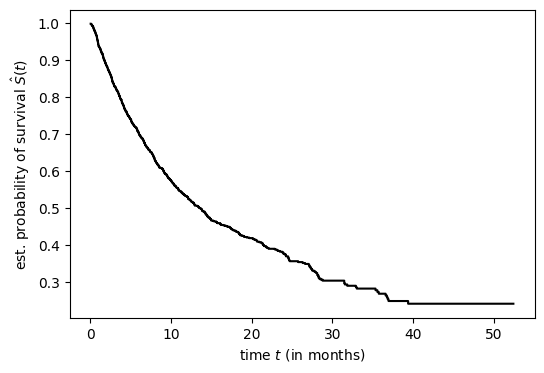

In [25]:
#Overall Survival
import matplotlib.pyplot as plt
train_df['vital_status'] = train_df['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

timedeath = train_df['OS']
timedeath[train_df['vital_status'] < 1.] #patients identified as died when vital status is 0.

statusdeath = [x > 0. for x in train_df['vital_status']] #creates a boolean whether whether x is greater than 0 or not
time, survival_prob = kaplan_meier_estimator(statusdeath, timedeath)

plt.figure(figsize=(6, 4))
plt.step(time, survival_prob, where="post", color="black")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (in months)")
plt.show()

## Cox Proportional Hazards Analysis

In [26]:
# (de Kamps, 2023)
import numpy as np

# Random seed for the future
np.random.seed(42)

#creates an numpy array by zipping together OS and vital status into a tupple, converting to list, and then array
dfy = np.array(list(zip(statusdeath, timedeath)), dtype=[('Status', '?'), ('Survival_in_months', '<f8')])
print(dfy)

[(False,  9.59) (False, 50.14) (False,  9.99) ... (False,  9.3 )
 (False, 11.56) ( True,  1.51)]


In [27]:
#"response" variable not included in model, as "best-response" provided more granular data, and provide overlapping information

#Final model included sex (2 levels), drug_class (2 levels), progression (2 levels), cancer_type (6 levels), overall survival (continuous), vital_status(2 levels)
#neutrophil to lymphocyte ratio, tumor mutational burden, age, best response to treatment, cancer stage, functional status (ECOG0)
#and microsatellite instability (3 levels)

columns_to_select = train_df.filter(like='sex').columns.tolist()
columns_to_select += train_df.filter(like='drug_class').columns.tolist()
columns_to_select += train_df.filter(like='progression').columns.tolist()
columns_to_select += train_df.filter(like='cancer_type').columns.tolist()
columns_to_select += ['OS', 'vital_status', 'nlr','tmb_mutations_mb', 'age_encoded', 
                      'best_response_encoded', 'stage_encoded', 'ECOG_encoded',
                      'msi_type_encoded'
                      ]

# Select the desired columns
selected_columns = train_df[columns_to_select]

# View the selected columns
print(selected_columns)



      sex=Male  drug_class=pd-1/pd-l1  progression=Yes  cancer_type=HNC  \
2          0.0                    1.0              1.0              0.0   
3          0.0                    0.0              1.0              0.0   
4          0.0                    1.0              1.0              0.0   
6          1.0                    1.0              1.0              0.0   
7          0.0                    1.0              1.0              0.0   
...        ...                    ...              ...              ...   
1697       0.0                    1.0              1.0              0.0   
1698       0.0                    1.0              1.0              0.0   
1699       1.0                    1.0              1.0              0.0   
1700       1.0                    1.0              1.0              0.0   
1701       0.0                    1.0              1.0              0.0   

      cancer_type=LGI  cancer_type=Lung  cancer_type=Melanoma  \
2                 0.0             

In [28]:
#Drop vital status and overall survival from dfx

dfx = selected_columns.drop(['vital_status', 'OS'], axis=1, inplace=False)

In [29]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#I want my dfx dataframe to contain all variables except vital_status and OS

dfx = selected_columns.drop(['vital_status', 'OS'], axis=1, inplace=False)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(dfx, dfy)

#This gives the C statistic
estimator.score(dfx, dfy)

0.7671083608758325

In [30]:
print("Shape of dfx:", dfx.shape)
print("Shape of dfy:", dfy.shape)


Shape of dfx: (1172, 15)
Shape of dfy: (1172,)


In [31]:
print(estimator.coef_)

[ 0.10941794 -0.1303408  18.87042749 -0.32101801  0.29339577 -0.02250559
 -0.50557712  0.43101471  0.28094354  0.02467725  0.03348118 -0.45220368
 -0.55406209  0.25262605 -0.0266936 ]


In [32]:
#Perform 3 fold CV validation, to give a mean C statistic across 3 folds
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator, dfx, dfy, cv=3)
print(f"Mean score CoxPH: {scores.mean():.3f} (std: {scores.std():.3f})")

Mean score CoxPH: 0.757 (std: 0.019)


## Use of Negative Partial Log Likelihood as  Loss Function

In [33]:
import torch 

# Adapted from Pölsterl (2023); de Kamps (2023)

#The code below are a number of helper functions utilized by Mbotwa et al 

#Implement an optimizer for CoxPH

class CoxPHOptimizer:
    """Negative partial log-likelihood of Cox proportional hazards model."""

    def __init__(self, X, event, time, alpha, ties):
        """Initialize the model.

        Args:
            X (pandas.DataFrame): The dataset.
            event (array): List of events.
            time (array): List of times.
            alpha (array): List of L2 penalties for each coefficient.
            ties (string): Which method to use for ties. One of 'breslow' or 'efron'.

        Raises:
            ValueError: If ties is not one of 'breslow' or 'efron'.
        """
        # Sort descending
        o = np.argsort(-time, kind="mergesort")
        self.x = torch.tensor(X[o, :], dtype=torch.float)
        self.event = event[o]
        self.time = time[o]
        self.alpha = alpha
        # Method to handle ties
        if ties not in ("breslow", "efron"):
            raise ValueError("ties must be one of 'breslow', 'efron'")
        ties = "breslow"
        self._is_breslow = ties == "breslow"

#Function to compute the negative partial log likelihood (PLL)
#Returns average PLL per event

    def nlog_likelihood(self, w=None, model=None):
        """Compute negative partial log-likelihood.

        Args:
            w (array, shape = (n_features,), optional): Estimate of coefficients. Defaults to None.
            model (torch.nn.Module, optional): The NN model. Defaults to None.

        Returns:
            float: Average negative partial log-likelihood (NPLL per event).
        """
        time = self.time
        n_samples = self.x.shape[0]
        breslow = self._is_breslow
        xw = []
                
        if model is not None:
            for i in range(n_samples):
                # Computes risk score for each sample using the NN model
                # and appends it to the list xw, containing the risk scores for all samples.
                xw.append(model.forward(self.x[i]))
                # self.update(model)
        else:
            #If no model we perform a matrix-vector product using the feature matrix self.x
            #and a vector of the weights (in a linear combination)
            #xw is the risk score
            xw = self.x@w

        #loss, risk_set and k(the index) are set to zero
        loss = 0
        risk_set = 0
        k = 0
        
        #Iterate until we reach the total number of samples in the dataset
        while k < n_samples:
            ti = time[k] #time of event for k index
            numerator = 0 #initialize variable for samples with events
            n_events = 0 #of events occuring at same time
            risk_set2 = 0 # samples without events at same time
            while k < n_samples and ti == time[k]: #iterate over samples with same event time
                if self.event[k]: #if sample has event
                    numerator = numerator + xw[k] #risk score added to numerator
                    risk_set2 = risk_set2 + torch.exp(xw[k]) #exponential of risk score added to risk_set2, accumulates scores for samples without event at same time
                    n_events = n_events + 1 #increment number of events happening at same time
                else:
                    risk_set = risk_set + torch.exp(xw[k]) #if sample does not have event, added to risk_set
                k = k + 1

#This part of the code defines different methods for dealing with ties (Breslow and Efron depending on what is selected)
            if n_events > 0:
                if breslow:
                    risk_set = risk_set + risk_set2
                    loss = loss - (numerator - n_events * torch.log(risk_set)) / n_samples
                else:
                    numerator = numerator/n_events
                    for _ in range(n_events):
                        risk_set = risk_set + risk_set2 / n_events
                        loss = loss - (numerator - torch.log(risk_set)) / n_samples

        return loss
    
    # function adapted for torch tensors instead of numpy arrays.
    def update(self, model, offset=0):
        """Compute and updates gradient and Hessian matrix.
        
        Args:
            model (torch.nn.Module): The NN model.
            offset (float, optional): The offset. Defaults to 0.
        """
        time = self.time
        x = self.x
        breslow = self._is_breslow
        n_samples, n_features = x.shape
        
        # Compute risk score for each sample using the NN model
        # Everything else in this function is the same as the original code
        exp_xw = []
        for i in range(n_samples):
            exp_xw.append(torch.exp(offset + model.forward(torch.tensor(x[i], dtype=torch.float32))).item())

        gradient = torch.zeros((1, n_features), dtype=torch.float64)
        hessian = torch.zeros((n_features, n_features), dtype=torch.float64)

        inv_n_samples = 1. / n_samples
        risk_set = 0
        risk_set_x = torch.zeros((1, n_features), dtype=torch.float64)
        risk_set_xx = torch.zeros((n_features, n_features), dtype=torch.float64)
        k = 0
        
        # Iterate time in descending order
        while k < n_samples:
            ti = time[k]
            n_events = 0
            numerator = 0
            risk_set2 = 0
            risk_set_x2 = torch.zeros_like(risk_set_x)
            risk_set_xx2 = torch.zeros_like(risk_set_xx)
            while k < n_samples and ti == time[k]:
                # Preserve 2D shape of row vector
                xk = x[k:k + 1]

                # Outer product
                xx = torch.matmul(xk.T, xk)

                if self.event[k]:
                    numerator += xk
                    risk_set2 += exp_xw[k]
                    risk_set_x2 += exp_xw[k] * xk
                    risk_set_xx2 += exp_xw[k] * xx
                    n_events += 1
                else:
                    risk_set += exp_xw[k]
                    risk_set_x += exp_xw[k] * xk
                    risk_set_xx += exp_xw[k] * xx
                k += 1

            if n_events > 0:
                if breslow:
                    risk_set += risk_set2
                    risk_set_x += risk_set_x2
                    risk_set_xx += risk_set_xx2

                    z = risk_set_x / risk_set
                    gradient -= (numerator - n_events * z) * inv_n_samples

                    a = risk_set_xx / risk_set
                    # outer product
                    b = torch.matmul(z.T, z)

                    hessian += n_events * (a - b) * inv_n_samples
                else:
                    numerator /= n_events
                    for _ in range(n_events):
                        risk_set += risk_set2 / n_events
                        risk_set_x += risk_set_x2 / n_events
                        risk_set_xx += risk_set_xx2 / n_events

                        z = risk_set_x / risk_set
                        gradient -= (numerator - z) * inv_n_samples

                        a = risk_set_xx / risk_set
                        # outer product
                        b = torch.matmul(z.T, z)

                        hessian += (a - b) * inv_n_samples

        self.gradient = gradient.ravel()
        self.hessian = hessian
    
    def zero(self):
        """Reset gradient and Hessian matrix."""
        self.gradient = 0
        self.hessian = 0

In [34]:
#Make sure only the columns with the predictors of interest are included (columns_to_select previously defined)
train_df = train_df[columns_to_select]
print(train_df.info)

<bound method DataFrame.info of       sex=Male  drug_class=pd-1/pd-l1  progression=Yes  cancer_type=HNC  \
2          0.0                    1.0              1.0              0.0   
3          0.0                    0.0              1.0              0.0   
4          0.0                    1.0              1.0              0.0   
6          1.0                    1.0              1.0              0.0   
7          0.0                    1.0              1.0              0.0   
...        ...                    ...              ...              ...   
1697       0.0                    1.0              1.0              0.0   
1698       0.0                    1.0              1.0              0.0   
1699       1.0                    1.0              1.0              0.0   
1700       1.0                    1.0              1.0              0.0   
1701       0.0                    1.0              1.0              0.0   

      cancer_type=LGI  cancer_type=Lung  cancer_type=Melanoma  \
2 

In [35]:
# (de Kamps, 2023)

%pip install lifelines

from lifelines import CoxPHFitter

from lifelines.utils import concordance_index

#This is another method of fitting a COXPH model

cph_IO = CoxPHFitter().fit(train_df, 'vital_status', 'OS')
cph_IO.print_summary(columns=["coef", "se(coef)", "p"])

# Store the coefficients
cph_IO_coef = cph_IO.summary['coef']

print(cph_IO.concordance_index_)





Note: you may need to restart the kernel to use updated packages.


<lifelines.CoxPHFitter: fitted with 1172 total observations, 0 right-censored observations>
             duration col = 'vital_status'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 1172
number of events observed = 1172
   partial log-likelihood = -6932.59
         time fit was run = 2024-03-14 22:03:36 UTC

---
                        coef   se(coef)      p
covariate                                     
sex=Male               -0.03       0.06   0.58
drug_class=pd-1/pd-l1   0.04       0.08   0.60
progression=Yes        -1.92       0.10 <0.005
cancer_type=HNC         0.19       0.16   0.23
cancer_type=LGI        -0.01       0.16   0.97
cancer_type=Lung        0.04       0.10   0.66
cancer_type=Melanoma    0.15       0.13   0.24
cancer_type=UGI         0.00       0.11   0.97
nlr                    -0.08       0.03   0.01
tmb_mutations_mb       -0.00       0.03   0.96
age_encoded            -0.02       0.02   0.35
best_response_encoded   0.10       0.03 <0.005
stage_encoded           0.10       0.13   0.45
ECOG_encoded           -0.05       0.04   0.16
msi_type_encoded        0.04       0.12   0.76
---
Concordance = 0.83
Partial AIC = 13895.17
log-likelihood ratio test = 363.53 on 15 df
-log2(p) of ll-ratio test = 224.26

0.8290976493998564


In [36]:

#I experimented a bit with different penelties. 
#It seems like no penelty is better, some exampels of lasso (l1) and ridge (l2) penalty
cph_IOa = CoxPHFitter(penalizer=0.01, l1_ratio=1).fit(train_df, 'vital_status', 'OS') # Set the penalizer value for L1 penalty
cph_IOa.print_summary(columns=["coef", "se(coef)", "p"])

# Store the coefficients
cph_IO_coef = cph_IOa.summary['coef']

cph_IOb = CoxPHFitter(penalizer=0.01, l1_ratio=0).fit(train_df, 'vital_status', 'OS') # Set the penalizer value for L2 penalty and l1_ratio=0 for Ridge penalty
cph_IOb.print_summary(columns=["coef", "se(coef)", "p"])

# Store the coefficients
cph_IO_coef = cph_IOb.summary['coef']


<lifelines.CoxPHFitter: fitted with 1172 total observations, 0 right-censored observations>
             duration col = 'vital_status'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 1172
number of events observed = 1172
   partial log-likelihood = -6944.90
         time fit was run = 2024-03-14 22:03:39 UTC

---
                        coef   se(coef)      p
covariate                                     
sex=Male               -0.01       0.06   0.82
drug_class=pd-1/pd-l1   0.01       0.08   0.94
progression=Yes        -1.89       0.10 <0.005
cancer_type=HNC         0.10       0.14   0.47
cancer_type=LGI        -0.00       0.00   1.00
cancer_type=Lung        0.00       0.00   1.00
cancer_type=Melanoma    0.08       0.10   0.43
cancer_type=UGI        -0.00       0.08   0.96
nlr                    -0.07       0.03   0.03
tmb_mutations_mb        0.00       0.00   1.00
age_encoded            -0.01       0.02   0.61
best_response_encoded   0.09       0.03   0.01
stage_encoded           0.07       0.13   0.58
ECOG_encoded           -0.04       0.04   0.25
msi_type_encoded        0.00       0.00   1.00
---
Concordance = 0.83
Partial AIC = 13919.80
log-likelihood ratio test = 338.91 on 15 df
-log2(p) of ll-ratio test = 207.15

<lifelines.CoxPHFitter: fitted with 1172 total observations, 0 right-censored observations>
             duration col = 'vital_status'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 1172
number of events observed = 1172
   partial log-likelihood = -6935.65
         time fit was run = 2024-03-14 22:03:39 UTC

---
                        coef   se(coef)      p
covariate                                     
sex=Male               -0.03       0.06   0.58
drug_class=pd-1/pd-l1   0.04       0.08   0.62
progression=Yes        -1.88       0.10 <0.005
cancer_type=HNC         0.18       0.16   0.24
cancer_type=LGI        -0.01       0.16   0.94
cancer_type=Lung        0.04       0.09   0.69
cancer_type=Melanoma    0.15       0.12   0.24
cancer_type=UGI        -0.00       0.11   0.99
nlr                    -0.08       0.03   0.01
tmb_mutations_mb        0.00       0.03   1.00
age_encoded            -0.02       0.02   0.35
best_response_encoded   0.10       0.03 <0.005
stage_encoded           0.10       0.13   0.44
ECOG_encoded           -0.05       0.04   0.16
msi_type_encoded        0.04       0.12   0.75
---
Concordance = 0.83
Partial AIC = 13901.30
log-likelihood ratio test = 357.40 on 15 df
-log2(p) of ll-ratio test = 220.00

## Test CoxPH Model in the Test Dataset

In [37]:


from lifelines.utils import concordance_index

# Extract the event times and vital status from the testing dataset
event_times = test_df['OS']
vital_status = test_df['vital_status']

# Calculate the C-statistic
c_index = concordance_index(event_times, cph_IO.predict_partial_hazard(test_df))
print("C-statistic:", c_index)


C-statistic: 0.6627653525398028


## Survival Analysis with CoxNNet

In [39]:
# Adapted from de Kamps (2023); Ching et al. (2018)- The authors of this code referenced de Kamps 2023, but I have not confidently identified
#the primary source.

torch.autograd.set_detect_anomaly = True

class CoxNNet(torch.nn.Module):
    """CoxNNet model for survival analysis."""

    #Define constructor for initialization of the model
    def __init__(self, df, event, time, coefficients=None):
        """Initialize the CoxNNet model.

        Args:
            df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
            event (str): Name of the event column. 
            time (str): Name of the time column.
            coefficients (torch.Tensor, optional): Initial coefficients. Defaults to None.
        """

        super().__init__()

        self.covariates = [x for x in df.columns if x != event and x != time]
        self.df = df
        self.dfx = df[self.covariates].to_numpy(dtype=float)
        self.events = df[event].to_numpy(dtype=float)
        self.times = df[time].to_numpy(dtype=float)
        
        n_covariates = len(self.covariates)
        
        # If no coefficients are passed in, we initialize them randomly
        if coefficients == None:
            # Set random seed for reproducibility
            torch.manual_seed(42)
            self.coefficients = torch.randn(n_covariates, requires_grad=True, dtype=torch.float)
        # Otherwise we use the coefficients passed in
        else:
            self.coefficients = coefficients.clone().detach().requires_grad_(True)
        
        # This line is used in coxpy to initialize the alphas
        alphas = torch.zeros(self.dfx.shape[1])
        
        self.opt = CoxPHOptimizer(self.dfx, self.events, self.times, alphas, 'breslow')

    def forward(self, model=None):
        """Calculate the log-likelihood over the entire dataset.
        This is the function that is called when we call net.forward().
        Important: this is where we can pass in a NN model.

        Args:
            model (torch.nn.Module, optional): NN model to use. Defaults to None.

        Returns:
            float: Log-likelihood over the entire dataset.
        """
        # sksurv calculates the log likelihood /event and puts a minus sign in front, we undo that
        total = -self.df.shape[0]*self.opt.nlog_likelihood(self.coefficients, model)
        return total

# Simply testing to make sure the code works
  

# Generate a tensor. THis needs to equal the number of covariates excluding vital_status and OS
num_features = 15

# Generate a tensor with random values for the coefficients, matching the number of features
c = torch.randn(num_features)
#c = torch.randn(26)

net = CoxNNet(train_df, 'vital_status', 'OS', coefficients=c)
loss = net.forward()
print("Loss:", loss.item())


Loss: -6067.97216796875


## Gradient Descent to Maximize the Partial Log Likelihood in CoxNNet

In [40]:
# Adapted from de Kamps (2023)
def gradient_descent(df, event, time, lr, n_epoch, coefficients=None):
    """Performs gradient descent on the Cox model.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs (iterations to run).
        coefficients (torch.Tensor, optional): Initial coefficients. Defaults to None.

    Returns:
        torch.nn.Module: The trained CoxNNet model (with updated coefficients).
    """
    
    net = CoxNNet(df, event, time, coefficients)
    loss = net.forward() #calculate initial loss by the forward method
    print("Initial Loss:", loss.item())
    
    # Iterate n_epoch times
    for _ in range(n_epoch):
        # Updates the coefficients using autograd
        loss = net.forward()
        loss.backward() #gradient of loss computed using backpropogation
        with torch.no_grad():
            # Use the specified learning rate
            net.coefficients += net.coefficients.grad * lr #coefficnets updated using GD
            net.coefficients.grad.zero_() #zeroed to prevent accumulation
    loss = net.forward()
    
    # Print the final loss and the updated coefficients
    print("Final Loss:", loss.item())
    print("Coefficients:", net.coefficients.detach().numpy())
    return net

#The two digits (0.0001, 4000)refer to the learning rate, and the number of epochs
cancer_net = gradient_descent(train_df, 'vital_status', 'OS', 0.0001, 4000)

Initial Loss: -6641.56787109375
Final Loss: -4216.68212890625
Coefficients: [ 0.10940876 -0.12528454  4.6666746  -0.31490743  0.30231103 -0.01661091
 -0.4978431   0.43564475  0.28147185  0.01755709  0.03397216 -0.4484328
 -0.55893165  0.2515649  -0.03114949]


## Gradient descent generalizable to other neural networks

In [41]:
# Train the NN using gradient descent
#in this function, a model parameter is explicitly passed as an argument in the function

def train_model(df, event, time, model, lr, n_epoch, output=False):
    """Trains a NN model using gradient descent.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (_type_): NN model.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs (iterations to run).
        output (bool, optional): Whether to print the loss before and after training. Defaults to True.
        
    Returns:
        float: The final loss.
    """
    net = CoxNNet(df, event, time)
    losses = []
    
    # Print the initial loss before training
    if output:
        print("Initial Loss:", net.forward(model).item())
    
    # Train the model
    for _ in range(n_epoch):
        # Compute the loss using the CoxNNet class and the NN model
        loss = net.forward(model)
        loss.backward()        
        losses.append(loss)
        
        # Update the weights using gradient descent
        with torch.no_grad():
            for param in model.parameters():
                param += param.grad * lr
            model.zero_grad()
    
    # Print the final loss
    if output:
        print("Final Loss:", net.forward(model).item())
        
        # Produce a plot of the loss over the epochs
        losses = [x.detach().numpy() for x in losses]
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, n_epoch+1), losses, color='black')
        plt.xlabel('Epochs')
        plt.ylabel('Negative Partial Log-Likelihood Loss')
        plt.show()
    
    # Return the final PLE loss of the final trained model
    return losses[-1]

## Helper function to calculate the C-statistic

In [42]:

#C statistic assesses the number of concordant, discordant, and tied pairs. 
#Ratio of sum of concordant pairs + half tied pair/total pairs

def concordance_statistic(risks, events, times, output=True):
    """Calculates the c-statistic for a given set of predicted risks and actual events and times.

    Args:
        risks (array): List of predicted risks.
        events (array): List of event indicators.
        times (array): List of survival times.

    Returns:
        float: c-statistic.
    """
    valid_pairs = 0
    concordant_pairs = 0
    discordant_pairs = 0
    tied_pairs = 0
    
    # Convert risks tensor to NumPy array
    if isinstance(risks, torch.Tensor):
        risks = risks.detach().cpu().numpy()
    
    # Sort risks, events, and times based on the times
    sorted_indices = np.argsort(times)
    risks = np.array(risks)[sorted_indices]
    events = np.array(events)[sorted_indices]
    times = np.array(times)[sorted_indices]

    n_samples = len(risks)
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if times[i] != times[j]:
                if events[i] and (times[i] < times[j]):
                    valid_pairs += 1
                    if risks[i] > risks[j]:
                        concordant_pairs += 1
                    elif risks[i] < risks[j]:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1

                elif events[j] and (times[j] < times[i]):
                    valid_pairs += 1
                    if risks[j] > risks[i]:
                        concordant_pairs += 1
                    elif risks[j] < risks[i]:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1
    
    # We can optionally produce a plot of the risk scores over time
    # This is useful for visualising the risk scores
    # Ideally, we would like to see the risk scores of the events (i.e. 1) higher than the non-events (i.e. 0)
    # This is because the risk scores are the log-hazard ratios
    if output:
        # Plots the risk scores over time
        plt.figure(figsize=(6, 4))
        colors = np.where(events, 'orange', 'blue')

        for color, label in zip(['orange', 'blue'], ['Event', 'Non-Event']):
            mask = (colors == color)
            plt.scatter(times[mask], np.array(risks)[mask], alpha=0.3, color=color, label=label)

        plt.xlabel('Time')
        plt.ylabel('Risk')
        plt.legend()
        plt.show()
    
    # Note we do not actually need to use discordant_pairs in the calculation
    # Since we already increment valid_pairs when we encounter a discordant pair
    return (concordant_pairs + 0.5 * tied_pairs) / valid_pairs

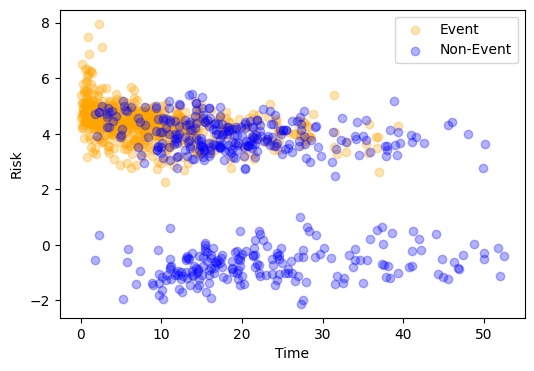

Base Cancer Score: 0.767158807068407


In [43]:
#Test the C-statistic function in the CoxNNet model

def get_concordance_statistic(df, event, time, net, output=True):
    """Calculates the c-statistic for a given dataset for the CoxNNet model.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        net (torch.nn.Module): CoxNNet model.

    Returns:
        float: c-statistic.
    """
    # Calculate the predicted risk for each individual in the dataset
    risks = np.matmul(net.dfx, net.coefficients.detach().numpy())
    
    return concordance_statistic(risks, df[event].to_numpy(), df[time].to_numpy(), output)

print("Base Cancer Score:", get_concordance_statistic(train_df, 'vital_status', 'OS', cancer_net))

In [44]:
#C statistic helper functions generalizable to other neural networks

def get_concordance_statistic_nn(df, event, time, model, output=True):
    """Calculates the c-statistic for a given dataset using a NN model to compute predicted risks.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (torch.nn.Module): NN model.
        output (bool, optional): Whether to print the loss before and after training. Defaults to True.

    Returns:
        float: c-statistic.
    """
    # Calculate the predicted risk for each individual in the dataset using the NN
    x = torch.tensor(df[[col for col in df.columns if col not in [event, time]]].values, dtype=torch.float)    
    with torch.no_grad():
        predicted_risk = np.array([model.forward(xi).item() for xi in x])
    
    # Compute the c-statistic
    return concordance_statistic(predicted_risk, df[event].to_numpy(), df[time].to_numpy(), output)

## Initialize Linear Model with Fixed Weights

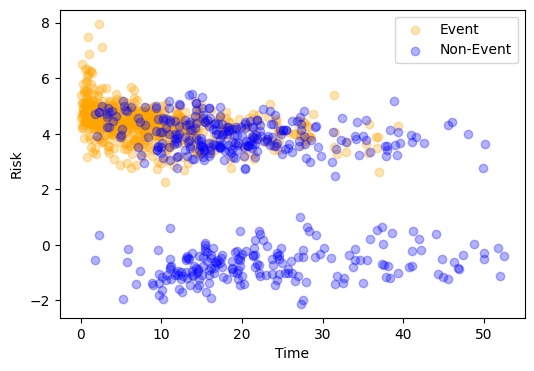

FWL Cancer Score: 0.7671569047089105


In [45]:
# Simple NN with no hidden layers, essentially the same as a CoxPH model. Unable to capture non linear relationships

class FixedWeightLinear(torch.nn.Module):
    """Simple NN with no hidden layers that simply computes the dot product of the input and the weights.
    This is essentially the same as the CoxPH model.
    We do not train this model, we simply use it to compute the predicted risk for each individual in the dataset.
    """
    
    def __init__(self, weights):
        """Initializes the FWL model.

        Args:
            weights (torch.Tensor): Weights to use for the dot product.
        """
        #"super" allows you to call methods from the parent class
        super(FixedWeightLinear, self).__init__()
        # Initialize the weights as a torch.nn.Parameter
        self.weights = torch.nn.Parameter(weights.clone().detach().requires_grad_(True))

    def forward(self, x):
        """Simply multiply the weights by the input.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return torch.matmul(x, self.weights)
    
# Initialize the FWL model with the learned coefficients
cancer_fwl = FixedWeightLinear(cancer_net.coefficients)

# Compute the c-statistic using the FWL model
print("FWL Cancer Score:", get_concordance_statistic_nn(train_df, 'vital_status', 'OS', cancer_fwl))

## Variable Weights Model

In [46]:
# This class lets us use random weights for each feature
class VariableWeightLinear(FixedWeightLinear):
    """Simple NN with no hidden layers that simply computes the dot product of the input and the weights.
    However, the weights are randomly initialized and then trained using gradient descent."""
    
    def __init__(self, n):
        """Initializes the VWL model.

        Args:
            n (int): Number of features in the dataset.
        """
        # Randomise weights
        torch.manual_seed(42)
        weights = torch.nn.Parameter(torch.randn(n, requires_grad=True, dtype=torch.float))
        super(VariableWeightLinear, self).__init__(weights)
        # Print these initial weights
        print("Initial VWL", self.weights)

    def forward(self, x):
        """Simply multiply the weights by the input.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        # Again, simply multiply the weights by the input
        return torch.matmul(x, self.weights)
    
# Initialize the VariableWeightLinear model
n_covariates = len([x for x in train_df.columns if x != 'vital_status' and x != 'OS']) #covariates exclude vital_status and OS
cancer_vwl = VariableWeightLinear(n_covariates)

# Compute the c-statistic using the trained VWL model
print("Initial VWL Cancer Score:", get_concordance_statistic_nn(train_df, 'vital_status', 'OS', cancer_vwl, False))

Initial VWL Parameter containing:
tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674,  0.5349,  0.8094,  1.1103, -1.6898, -0.9890],
       requires_grad=True)
Initial VWL Cancer Score: 0.3892227529805217


In [47]:
# Train the model using the train_model function previously defined.
cancer_vwl_loss = train_model(train_df, 'vital_status', 'OS', cancer_vwl, 0.0001, 4000, False)

# Compute the c-statistic using the trained VWL model
cancer_vwl_c = get_concordance_statistic_nn(train_df, 'vital_status', 'OS', cancer_vwl, False)

# Print the trained weights and loss in format string
print("Trained VWL Weights: {0} \
      \nTrained VWL Loss: {1} \
      \nTrained VWL Score {2}"
      .format(cancer_vwl.weights, cancer_vwl_loss, cancer_vwl_c))

Trained VWL Weights: Parameter containing:
tensor([ 0.1094, -0.1253,  4.6667, -0.3149,  0.3023, -0.0166, -0.4978,  0.4356,
         0.2815,  0.0176,  0.0340, -0.4484, -0.5589,  0.2516, -0.0312],
       requires_grad=True)       
Trained VWL Loss: -4216.68212890625       
Trained VWL Score 0.767158807068407


## Single Neural Network

In [49]:
def plot_weights(weights):
    """Plots the distribution of the weights.

    Args:
        weights (torch.Tensor): Weights to plot.
    """
    
    plt.figure(figsize=(6, 4))
    plt.hist(weights, bins=int(np.sqrt(len(weights))), color='black')
    plt.xlabel('Weights')
    plt.ylabel('Frequency')
    plt.show()

class SNN(torch.nn.Module):
    """Simple NN with one hidden layer."""
    
    def __init__(self, input_size, hidden_size=None):
        """Initializes the SNN model.

        Args:
            input_size (int): Number of covariates.
            hidden_size (int): Number of neurons in the hidden layer.
        """
        
        # Randomise weights
        torch.manual_seed(42)
        
        super(SNN, self).__init__()
        # Store the input and hidden sizes
        self.input_size = input_size
        # If no hidden size is specified, use the sqrt(input_size + 1) rounded up
        if hidden_size is None:
            self.hidden_size = np.sqrt(input_size + 1).astype(int) + 1
        else:
            self.hidden_size = hidden_size
        
        # Create the layers
        self.fc1 = torch.nn.Linear(input_size, hidden_size) #creates first fully connected layer 
        #with specified input size and hidden size. Performs linear tranformation of data
        self.relu = torch.nn.ReLU() #non linear activation function
        self.fc2 = torch.nn.Linear(hidden_size, 1) #produces a single output layer
        
        # Create the model
        self.model = torch.nn.Sequential(self.fc1, self.relu, self.fc2)

    def forward(self, x):
        """Predicts the risk for a single individual.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return self.model(x)
    
    def return_weights(self):
        """Plots the weights in a histogram."""
        
        plot_weights(torch.cat([self.fc1.weight.view(-1), self.fc1.bias, self.fc2.weight.view(-1), self.fc2.bias]).detach().numpy())

## Test Different Architectures of the NN model

Initial Loss: -4584.9404296875
Final Loss: -4231.87890625


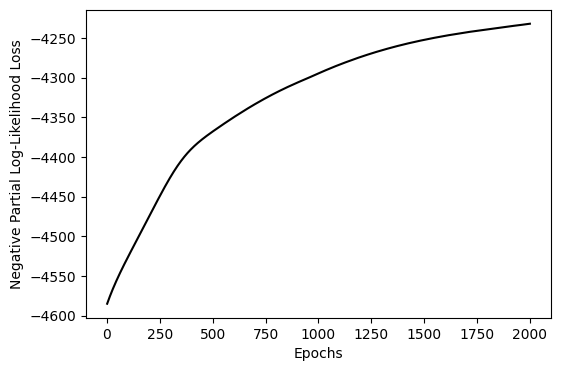

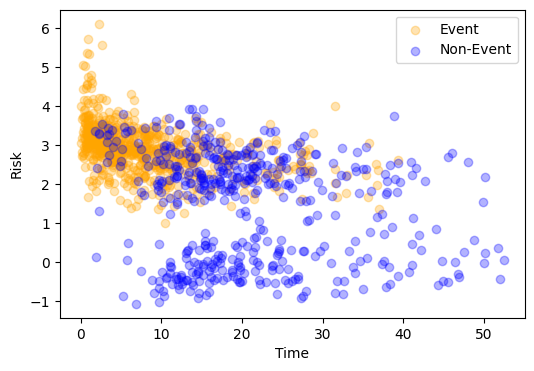

SNN[15, 5, 1] 
- Loss: [-4231.92]
- Score: 0.7681290104116135


(array([-4231.92], dtype=float32), 0.7681290104116135)

In [50]:
# This allows us to test different architectures of the `NN` model
def test_nn(df, event, time, model, lr, n_epoch, output=False):
    """Trains the model and prints the c-statistic.

    Args:
        df (pandas.DataFrame): Dataset to use.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (torch.nn.Module): NN model.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs.
        output (bool, optional): Whether to print the output. Defaults to False.
    """
    
    loss = train_model(df, event, time, model, lr, n_epoch, output)
    score = get_concordance_statistic_nn(df, event, time, model, output)
    
    if output:
        # Print format string with loss and score
        param = ""
        if type(model).__name__ == "SNN":
            param = f"[{model.input_size}, {model.hidden_size}, 1]"
        elif type(model).__name__ == "GNN": 
            param = model.layer_sizes
        print(f"{type(model).__name__}{param} \n- Loss: {loss}\n- Score: {score}")
    return loss, score

#Note, for this dataset, the kernel "dies" if you set the EPOCH to 4000

# Test the simple model on the cancer data set
#The learning rate controls the step size taken during each parameter update
input_size = train_df.shape[1] - 2  # Number of input features (excluding vital status and overall survival
hidden_size = (np.sqrt(input_size + 1)).astype(int) + 1  # Number of hidden units. Taking the square root allows scaling of the number of the hidden units. Adding "1" ensures a minimum number obtained
cancer_snn = SNN(input_size, hidden_size)

#The final NN size will therefore be 15, sqrt(15)+1, 1 units
test_nn(train_df, 'vital_status', 'OS', cancer_snn, 0.00001, 2000, True)

## Tuning Different Neural Network Architecture

In [51]:

# Create a loop to test different architectures (begin with 1 neuron in single hidden layer, increase in steps of 1 until 2 * input_size)
cancer_snn_losses = []
cancer_snn_scores = []

# This allows us to test different architectures of the NN model
# We do not want to add too many neurons because this can lead to overfitting OR "dead neurons"
cancer_snn_hidden_sizes = [1 + i for i in range(input_size * 2)]

# This stores the best model and its score
cancer_snn_best = [None, 0, 0]

# Loop through the different architectures
for i in cancer_snn_hidden_sizes:
    model = SNN(input_size, i)
    loss, score = test_nn(train_df, 'vital_status', 'OS', model, 0.0001, 1000, False)
    loss = loss.detach().numpy()
    if score > cancer_snn_best[2]:
        cancer_snn_best = [model, loss, score]
    cancer_snn_losses.append(loss)
    cancer_snn_scores.append(score)

# Print the scores of the best architecture
print("Best SNN: \
    \n- Architecture: SNN[{0}, {1}, 1] \
    \n- Loss: {2} \
    \n- Score: {3}"
    .format(input_size, cancer_snn_best[0].hidden_size, cancer_snn_best[1], cancer_snn_best[2]))

KeyboardInterrupt: 

In [ ]:
# Plot the losses
plt.figure(figsize=(6, 4))
plt.scatter(cancer_snn_hidden_sizes, cancer_snn_losses, label='Loss', color='black')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Loss ')
plt.show()

# Plot the c-statistic scores
plt.figure(figsize=(6, 4))
plt.scatter(cancer_snn_hidden_sizes, cancer_snn_scores, label='C-Statistic', color='black')
plt.xlabel('Hidden Layer Size')
plt.ylabel('C-Statistic')
plt.show()

In [ ]:
# Use a histogram with n_bins = size of data square root
cancer_snn_best[0].return_weights()

## Further Generalization of Model Structure

In [52]:
class GNN(torch.nn.Module):
    """General NN with any number of hidden layers with any number of neurons."""
    
    def __init__(self, layer_sizes):
        """Initializes the GNN model.

        Args:
            layer_sizes (array): List of the number of neurons in each layer.
        """
        
        # Randomise weights
        torch.manual_seed(42)
        super(GNN, self).__init__()
        self.layer_sizes = layer_sizes
        # Create a list of layers
        self.layers = torch.nn.ModuleList()        
        # Create the layers based on the input sizes
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            # Add a ReLU activation function after every linear layer except the last one
            if i < len(layer_sizes) - 2:  # Don't add ReLU activation after the last linear layer
                self.layers.append(torch.nn.ReLU())
        # Create the model
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        """Predicts the risk for a single individual.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return self.model(x)

    def return_weights(self):
        """Plots the weights in a histogram."""
        
        weights = []
        for layer in self.layers:
            if type(layer).__name__ == "Linear":
                weights.append(layer.weight.view(-1))
                weights.append(layer.bias)
                
        plot_weights(torch.cat(weights).detach().numpy())

Initial Loss: -4552.39453125
Final Loss: -4080.839599609375


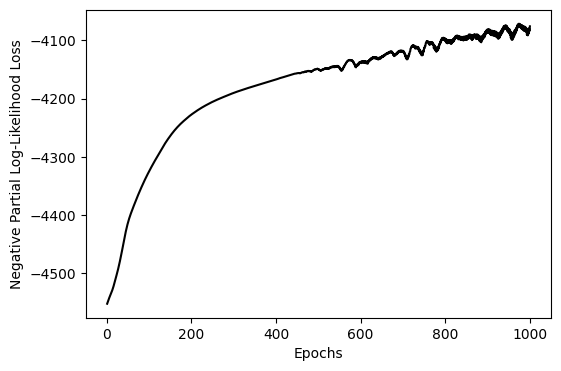

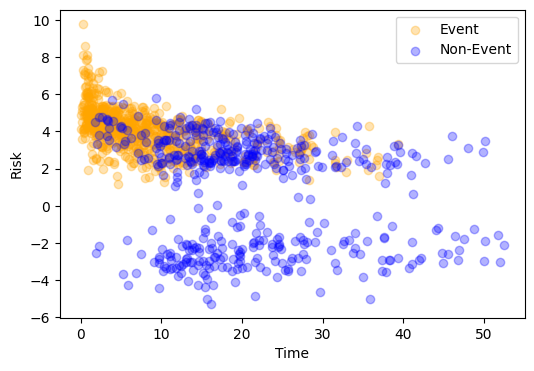

GNN[15, 30, 15, 1] 
- Loss: [-4075.8882]
- Score: 0.8065205274101468


(array([-4075.8882], dtype=float32), 0.8065205274101468)

In [53]:

cancer_architecture = [15, 30, 15, 1] 
cancer_gnn = GNN(cancer_architecture)
test_nn(train_df, 'vital_status', 'OS', cancer_gnn, 0.0001, 1000, True)

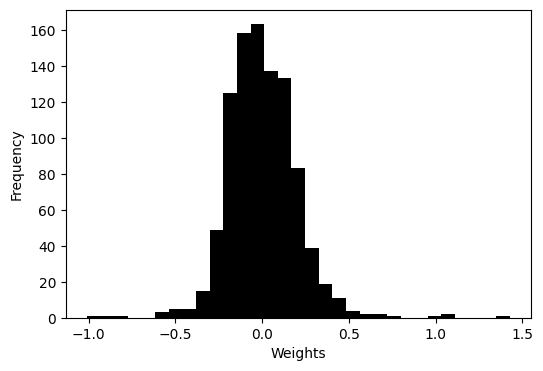

In [54]:
# Visualise weights of the GNN model using a histogram
# We expect there to be exponentially more weights in the GNN model than the SNN model
cancer_gnn.return_weights()

## Latent Class Analysis

In [55]:
%pip install scikit-learn
from sklearn.mixture import GaussianMixture


class LCA:
    """Latent Class Analysis model for survival analysis."""
    
    def __init__(self, df, event, time, n_components=2, architecture=None):
        """Initialises the LCA model.

        Args:
            df (pandas.DataFrame): Dataframe containing the data.
            event (str): Name of the event column.
            time (str): Name of the time column.
            n_components (int, optional): Number of components in the Gaussian Mixture Model. Defaults to 2.
            architecture (torch.Tensor, optional): Architecture of the GNN model. Defaults to None.
        """
        self.components = n_components #input size based on number of columns in dataset
        self.df = df
        self.event = event
        self.time = time
        
        # Initialise the covariates and the sizes
        self.input_size = len(self.df.columns) - 3 #subtract OS, vital status and class
        
        # If the architecture is not None, we use the architecture provided
        if architecture is None:
            self.architecture = [self.input_size, 
                                 self.input_size + 1, np.sqrt(self.input_size + 1).astype(int) + 1,
                                 1]
        else:
            self.architecture = architecture
        # Initialise the models
        # We use GNNs as the models because they are more flexible than SNNs
        gnn = GNN(self.architecture)
        self.models = [gnn for _ in range(n_components)]
        # Initialise the Gaussian Mixture Model, a parametric model which permits clustering
        # We set the random seed for reproducibility
        self.gmm = GaussianMixture(n_components=n_components, random_state=np.random.seed(42))
        
        # Stores dataframe for each latent class
        self.classes = []
        
        # Store risks for each each patient
        self.risks = []

    def fit(self):
        """Fits the LCA model to the dataset. and creates the seprate latent classes."""
        
        # Fit Gaussian Mixture Model to the dataset using Expectation Maximisation algorithm
        self.gmm.fit(self.df)
        
        # Assign patients to the latent classes
        self.df['LatentClass'] = self.gmm.predict(self.df)
    
    def train(self, lr=0.00001, epochs=1000, output=False):
        """Trains the GNN models for each latent class.
        
        Args:
            lr (float, optional): Learning rate. Defaults to 0.00001.
            epochs (int, optional): Number of epochs. Defaults to 1000.
            output (bool, optional): Whether to print the loss and output loss graph. Defaults to False.
        
        Returns:
            float: Total loss of the model.
        """  

        # Append the dataframes for each latent class to the classes list
        for i in range(self.components):
            #Latent class column equals the latent class index
            self.classes.append(self.df.loc[self.df['LatentClass'] == i].drop('LatentClass', axis=1))
            # Remove the latent class column from the dataframe
            self.classes[i] = self.df.drop('LatentClass', axis=1)        
            
        # Initialise the total loss
        total_loss = 0
        
        # For each model, train the model on the data for the given latent class
        for i, model in enumerate(self.models):
            # Train the model of the latent class
            loss = train_model(self.classes[i], self.event, self.time, model, lr, epochs, output)
            print("Loss for latent class " + str(i) + ": " + str(loss.detach().numpy()))
            # Add the loss to the total loss (remember the loss is negative)
            total_loss += -loss
        
        return total_loss.detach().numpy()
    
    def predict(self):
        """Produces the predictions for each patient in the dataset and computes the final loss and Score."""

        classes = []
        # Iterate over all patients and compute the risk for each patient using the appropriate model
        for _, x in self.df.iterrows():
            latent_class = x['LatentClass']
            # Get the model for the patient
            model = self.models[int(latent_class)]
            # Remove LatentClass, time and event column from the patient data
            x = x.drop('LatentClass').drop(self.event).drop(self.time)
            # Make patient a tensor
            x = torch.tensor(x.to_numpy(), dtype=torch.float32)
            # Compute the risk for the patient
            with torch.no_grad():
                risk = model.forward(x)
            # Append the risk to the list of risks
            self.risks.append(risk)
            
        # Use the predicted risks to compute the score  
        return concordance_statistic(self.risks, self.df[self.event].to_numpy(), self.df[self.time].to_numpy(), True)

Note: you may need to restart the kernel to use updated packages.


0    1172
Name: LatentClass, dtype: int64
Loss for latent class 0: [-4135.656]


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/2333271248.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  risks = np.array(risks)[sorted_indices]
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_13972/2333271248.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  risks = np.array(risks)[sorted_indices]


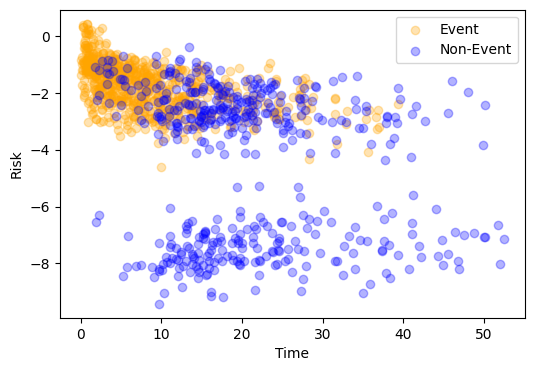

Total Loss: [4135.656] 
Score: 0.7940619750676764


In [56]:
def lca(df, event, time, n=2, architecture=None, lr=0.0001, epochs=1000, output=False):
    """Function to fit the LCA model and train the GNN models.

    Args:
        df (pandas.DataFrame): Dataframe containing the data
        event (str): Name of the event column
        time (str): Name of the time column
        n (int): Number of latent classes
        architecture (list, optional): Architecture of the GNN model. Defaults to None.
        lr (float, optional): Learning rate. Defaults to 0.0001.
        epochs (int, optional): Number of epochs. Defaults to 1000.
        output (bool, optional): Whether to print the loss and output loss graph. Defaults to False.

    Returns:
        LCA: Fitted LCA model.
    """
    X = df.copy()

    # Initialise LatentClass column as 0
    X['LatentClass'] = 0

    # Fits the LCA model
    model = LCA(X, event, time, n_components=n, architecture=architecture)
    model.fit()
    
    # Print the number of observations in each latent class
    print(model.df['LatentClass'].value_counts())
    
    # Trains the GNN models
    loss = model.train(lr, epochs, output)
    
    score = model.predict()
    
    print("Total Loss: {0} \nScore: {1}".format(loss, score))
    
    return model

#Test for implementation
cancer_lca1 = lca(train_df, 'vital_status', 'OS', 1)

In [ ]:
#While I categorized cancer subtypes into 6 grouping, there are actually 10 different distinct subtypes, so I will choose
#this as my number of latent classes. (SCLC, NSCLC melanoma, hepatobiliary, gastric, pancreatic, renal, bladder, esophageal, H and N)

cancer_lca10 = lca(train_df, 'vital_status', 'OS', 10)

In [57]:
#Include architecture for previously trained GNN model using the number of latent classes 
#The LCA helps to identify underlying subgroups within the structure of the NN

cancer_lca10_arch = lca(train_df, 'vital_status', 'OS', 10, cancer_architecture)

0    599
3    319
7     82
4     51
2     36
9     35
1     15
8     13
6     11
5     11
Name: LatentClass, dtype: int64
Loss for latent class 0: [-4075.8882]


## Convolutional Neural Networks

In [ ]:

# Create a simple CNN
class CNN(torch.nn.Module):
    """Simple CNN model for survival analysis."""
    def __init__(self, df, event, time, width=0, height=0):
        """Initialises the CNN model.
        
        Args:
            df (pandas.DataFrame): Dataframe containing the data
            event (str): Name of the event column
            time (str): Name of the time column
            width (int, optional): Width of the input image. Defaults to 0.
            height (int, optional): Height of the input image. Defaults to 0.
        """
        
        super(CNN, self).__init__()
        
        # Dataframe containing the data
        self.df = df
        
        # Event and time columns
        self.event = event
        self.time = time
                
        # Dataframe containing covariates
        self.dfx = self.df.drop([self.event, self.time], axis=1, inplace=False)
        # Convert dataframe to numpy array
        self.df_samples = self.dfx.to_numpy()
        
        # Calculate the optimal width and height based on the number of covariates
        #in the dataset unless otherwise specified.
        if width == 0 or height == 0:
            self.width, self.height = self.get_optimal_dimensions(self.dfx.shape[1])
        else:
            self.width = width
            self.height = height
        
        # Use random seed for reproducibility
        torch.manual_seed(42)
        
        # Create the model
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        #input channel = 1. This generally refers to greyscale data (eg 3 for RGB image)
        #output channel = 32. I left as is, based on what the authors did
        #kernel_size = 3*3, determines receptive field. Other choices include 5*5, 7*7
        #stride = the step size.
        #padding = # of pixels added to borders of input data
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #This refers to the max-pooling layer- the kernel is the size of the pooling layer, the stride
        #is the step size, the padding as above.

        self.fc1 = torch.nn.Linear(32 * (self.width // 2) * (self.height // 2), 128)
        #defines the fully connected linear layer

        self.fc2 = torch.nn.Linear(128, 1)
        self.layers = [self.conv1, self.pool, self.fc1, self.fc2]
        self.model = torch.nn.Sequential(*self.layers)
        
        # Transform the data
        self.transform()

    def forward(self, x):
        """Produces risk scores for the given patient image.

        Args:
            x (torch.Tensor): Patient image

        Returns:
            float: Risk score
        """
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        #apply first convolutional layer to input tensor --> ReLU activation then max pooling.

        x = x.view(-1, 32 * (self.width // 2) * (self.height // 2))
        #reshapes into a 1D tensor

        x = torch.nn.functional.relu(self.fc1(x))
        #apply 1st fully connected layer to reshaped tensor
        x = self.fc2(x)
        #apply 2nd fully connected layer to output of previous layer --> final output tensor
        return x
    
    def transform(self):
        """Transforms the data to be used by the model."""
        
        # Convert features to images
        self.images = [self.features_to_image(x, self.width, self.height) for x in self.df_samples]
        # Prepare the data for the CNN
        self.tensors = [torch.tensor(image, dtype=torch.float32).unsqueeze(0) for image in self.images]
        self.tensor = torch.stack(self.tensors)
        self.labels = torch.tensor(self.df[self.event].to_numpy(), dtype=torch.float32).unsqueeze(1)

    def train(self, lr=0.0001, epochs=1000, output=True):
        """Trains the model.
        
        Args:
            lr (float): Learning rate
            epochs (int): Number of epochs
            output (bool, optional): Whether to output the loss plot. Defaults to True.
        """
        
        # Note we use a custom optimizer here as the original classes are not suitable
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scores = []

        for _ in range(epochs):
            optimizer.zero_grad()

            # Forward pass
            outputs = self.forward(self.tensor)

            # Calculate concordance statistic
            score = concordance_statistic(outputs, self.df[self.event].to_numpy(), self.df[self.time].to_numpy(), output=False)

            # Calculate the negative of the concordance statistic to maximize it
            loss = -torch.tensor(score, requires_grad=True)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Save score
            scores.append(score)
            
        # Plot losses
        if output:
            plt.figure(figsize=(6, 4))
            plt.plot(scores)
            plt.xlabel('Epoch')
            plt.ylabel('Score')
            plt.show()
            
    def get_optimal_dimensions(self, n_features):
        """Calculate the optimal width and height for a given number of features.
        
        Args:
            n_features (int): Number of features
            
        Returns:
            tuple: Optimal width and height
        """
        
        #calculate square root of features
        sqrt_n_features = int(np.sqrt(n_features))
        if sqrt_n_features * sqrt_n_features == n_features:
            return sqrt_n_features, sqrt_n_features
        else:
            for i in range(sqrt_n_features + 1, n_features + 1):
                if n_features % i == 0:
                    return i, n_features // i
        
    # Convert features to images
    def features_to_image(self, features, width, height):
        """Converts features given a patient to an image.
        
        Args:
            features (np.array): Features of a patient
            width (int): Width of the image
            height (int): Height of the image
            
        Returns:
            np.array: Image of the features
        """
        
        # Normalize the features
        normalized_features = (features - np.min(features)) / (np.max(features) - np.min(features))

        # Calculate the required number of padding zeros
        num_features = len(features)
        target_size = width * height
        padding_zeros = target_size - num_features

        # If padding is required, add zeros to the features
        if padding_zeros > 0:
            normalized_features = np.concatenate((normalized_features, np.zeros(padding_zeros)))

        # Reshape the features to the desired width and height
        image = normalized_features.reshape(width, height)
        return image
        
    def return_weights(self):
        """Plots the weights in a histogram."""
        
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'weight'):
                weights.append(layer.weight.view(-1))
                
        plot_weights(torch.cat(weights).detach().numpy())
        
    def plot_image(self, x):
        """Plots the feature image of a patient. Converts the image to an actual image.

        Args:
            x (int): Index of the patient in the dataframe.
        """
        plt.figure(figsize=(6, 4))
        plt.imshow(self.images[x], cmap='gray')
        plt.show()
        
    def score(self):
        return f"Score: {concordance_statistic(self(self.tensor).detach().numpy(), self.df[self.event].to_numpy(), self.df[self.time].to_numpy(), True)}"

In [ ]:


cancer_cnn = CNN(cancer_scaled, 'vital_status', 'OS')
cancer_cnn.plot_image(0)

In [ ]:
cancer_cnn.train()

In [ ]:
cancer_cnn.score()

In [ ]:
cancer_cnn.return_weights()

## Testing of Best Model in Holdover Test Dataset

In [ ]:
print("Base Cancer Score:", get_concordance_statistic(train_df, 'vital_status', 'OS', cancer_net))

# Step 4: Obtain predictions
predictions = cancer_lca10.forward(cancer_lca10.tensor_test)

# Step 5: Evaluate the model
# For example, calculate the concordance index
c_index = concordance_index(test_df['OS'], -predictions.detach().numpy(), test_df['vital_status'])
print("Concordance Index (C-statistic) on Test Data:", c_index)



from lifelines.utils import concordance_index

# Extract the event times and vital status from the testing dataset
event_times = test_df['OS']
vital_status = test_df['vital_status']

# Calculate the C-statistic
c_index = concordance_index(event_times, cph_IO.predict_partial_hazard(test_df))
print("C-statistic:", c_index)
